# Notebook to generate coordinate file for moth simulations

## Set up

In [48]:
import sys
sys.path.append('/Users/sstk4353/packages/.')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [49]:
np.random.seed(42)  # For reproducibility

## Useful functions

Generating a truncated normal distribution for pitch angles

In [50]:
def discrete_truncated_normal_pmf(mean, spread, lower=0, upper=25):
    """
    Returns a DataFrame with pitch values from lower to upper, and the corresponding
    probabilities from a truncated normal distribution (discretized).

    The truncated normal is defined over a continuous range 


    Each discrete integer pitch is assigned a probability equal to the integral of the PDF between pitch - 0.5 and pitch + 0.5,

    The probabilities are renormalized to ensure they sum to 1.


    """
    # Define truncation in standard normal space
    a = (lower - mean) / spread
    b = (upper - mean) / spread
    # Create the truncated normal distribution
    dist = truncnorm(a=a, b=b, loc=mean, scale=spread)

    # Generate discrete pitch values
    pitch_vals = np.arange(lower, upper + 1)

    # Compute probabilities for each integer by integrating the PDF over integer bins
    pmf = []
    for pitch in pitch_vals:
        p = dist.cdf(pitch + 0.5) - dist.cdf(pitch - 0.5)
        pmf.append(p)

    # Normalize to ensure total probability is exactly 1 (safety)
    pmf = np.array(pmf)
    pmf /= pmf.sum()

    # Package into a DataFrame
    df = pd.DataFrame({
        'pitch': pitch_vals,
        'p(x)': pmf
    })

    return df

## Specify parameters for radar, range, and insect density

Specify basic radar parameters:

In [51]:
range_gate_separation = 600 # meters
radar_beam_width = 1 #degree
range_of_observation = 15000 # meters
beam_angle = 0.5 # degrees

Approximate radar sample volume as a cylinder, centred on range of observation

In [52]:
radius = range_of_observation*np.deg2rad(radar_beam_width)/2 # meters
volume = np.pi * radius**2 * range_gate_separation # cubic meters
print(f"Radar beam radius: {radius} m")
print(f"Radar volume size: {volume} m^3")

Radar beam radius: 130.89969389957471 m
Radar volume size: 32298204.87531231 m^3


Now we want to populate the cylinder with a grid of points representing our scatterers, to do this we need a scatterer density.

**NB** if you are planning to remove some scatterers, you might want to scale up your density by 1/(removal probability) 

This density is taken from Huang et al. 2024 for "medium" migrating insects, and matches Drake and Reynolds chapter 10 (2012) - I suspect it is possibly a bit high.

In [53]:
density = 10e-5 # scatterers per cubic meter

From our density we can calculate the number of scatterers and their spacing

In [54]:
n_scatterers = int(density * volume) # number of scatterers in the cylinder
spacing = ((1/density)**(1/3)) # spacing between scatterers in meters

print(f"Estimated number of scatterers: {n_scatterers}"
      f"\nSpacing between scatterers: {spacing} m")

Estimated number of scatterers: 3229
Spacing between scatterers: 21.544346900318832 m


## Coodinates

Now we need to fill our cylinder with a set of coordinate grid points. First define the possible sets of x, y and z values.

In [55]:
x_vals = np.arange(-range_gate_separation/2, range_gate_separation/2 + spacing, spacing)
y_vals = np.arange(-radius, radius + spacing, spacing)
z_vals = np.arange(-radius, radius + spacing, spacing)

First we check which grid points fall within the cylinder, as using this method some will fall outside, then we rotate all of the coordinates to account for the slant of the cylinder

**NB** I have left out perturbing the scatterer positions as this feels a little arbitrary.

In [56]:
data = []
cos_t = np.cos(np.deg2rad(-beam_angle))
sin_t = np.sin(np.deg2rad(-beam_angle))

for ix, x in enumerate(x_vals):
    for iy, y in enumerate(y_vals):
        for iz, z in enumerate(z_vals):
            if y**2 + z**2 <= radius**2:
                # Rotate around y-axis: tilt cylinder in x–z plane
                x_rot = x * cos_t + z * sin_t
                y_rot = y
                z_rot = -x * sin_t + z * cos_t

                distance = np.sqrt(x_rot**2 + y_rot**2 + z_rot**2)
                index_str = f"{ix}_{iy}_{iz}"

                data.append({
                    "index": index_str,
                    "x": x_rot,
                    "y": y_rot,
                    "z": z_rot,
                    "distance_to_center": distance
                })

df = pd.DataFrame(data)
df.set_index("index", inplace=True)



In [57]:
df.head()

,x,y,z,distance_to_center
index,,,,
0_1_3,-299.410299,-109.355347,-68.882091,326.113264
0_1_4,-299.598306,-109.355347,-47.338564,322.426234
0_1_5,-299.786314,-109.355347,-25.795038,320.149668
0_1_6,-299.974321,-109.355347,-4.251511,319.313734
0_1_7,-300.162329,-109.355347,17.292016,319.929726


## View scatterers

In [58]:
def plot_cylinder_points(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract coordinates and distance
    xs = df['x'].values + range_of_observation*np.cos(np.deg2rad(beam_angle))  # Adjust x for beam angle
    ys = df['y'].values 
    zs = df['z'].values + range_of_observation*np.sin(np.deg2rad(beam_angle))
    colors = df['distance_to_center'].values

    

    # Plot point cloud
    scatter = ax.scatter(xs, ys, zs, c=colors, cmap='viridis', s=5, alpha=0.8)

    # Axes labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Slanted Cylinder Point Cloud')

    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax, label='Distance to Center')
    cbar.ax.set_ylabel('Distance from origin (m)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

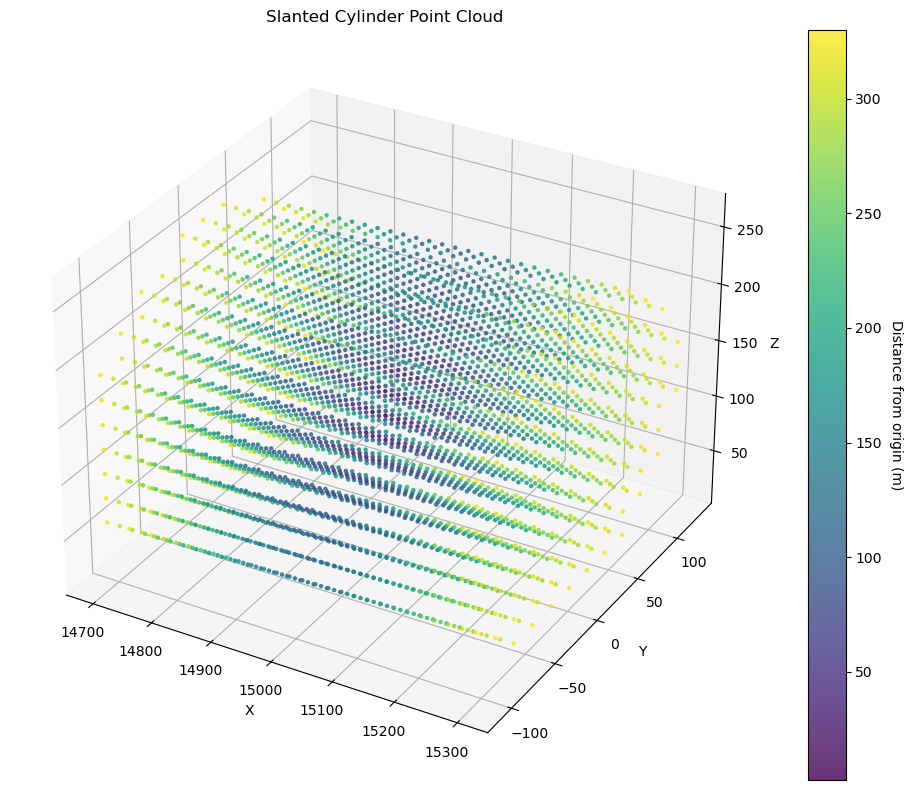

In [59]:
plot_cylinder_points(df)

## Metadata & scatterer characteristics

First add the radar and density information as metadata:

In [60]:
# Update to contain everything one needs to reconstruct simulation
df.attrs = {
    "radar_beam_width": radar_beam_width,
    "range_of_observation": range_of_observation,
    "range_gate_separation": range_gate_separation,
    "beam_angle": beam_angle,
    "density": density,
}

Now add metadata to each row giving scatterer characteristics, namely:
- name of scatterer
- size of scatterer
- pitch
- heading

We do this using a key of the form `namecode_size_pitch_heading`

We also add a flag to indicate whether this grid point is in use in the current simulation or not.

### Define scatterer params

Taken from Valery's fitting for now

In [61]:
mean_heading = 0 
heading_spread = 20 # degrees
mean_pitch = 11
pitch_spread = 10 # degrees
pitch_probability_df = discrete_truncated_normal_pmf(mean_pitch, pitch_spread, lower=0, upper=25)


In [62]:
df.attrs['mean_heading'] = mean_heading
df.attrs['heading_spread'] = heading_spread
df.attrs['mean_pitch'] = mean_pitch
df.attrs['pitch_spread'] = pitch_spread

In [63]:
string_list = []
size_list = []
heading_list = []
pitch_list = []

name = 'Xxanth' # for Xestia xanthographa
name_list = [name] * len(df)

for _ in range(len(df)):
    size = 17
    
    heading = int(np.random.normal(mean_heading, heading_spread))

    #heading = heading_sample if heading_sample>0 else 360 + heading_sample  # Ensure heading is positive
    pitch = int(np.random.choice(pitch_probability_df['pitch'], p=pitch_probability_df['p(x)']))
    string_list.append(f"{name}_{size}_{heading}_{pitch}")
    size_list.append(size)
    heading_list.append(heading)
    pitch_list.append(pitch)

df['scatterer_id'] = string_list
df['size'] = size_list
df['heading'] = heading_list
df['pitch'] = pitch_list



## Calculate projected distances for phase calculation

In [64]:
beam_vector = np.array([np.cos(np.deg2rad(beam_angle)), 0, np.sin(np.deg2rad(beam_angle))])

In [65]:
# Project each (x, y, z) coordinate from df onto beam_vector
df['relative_distance_along_beam'] = df[['x', 'y', 'z']].values @ beam_vector

## Check and save df

In [66]:
df.head()

,x,y,z,distance_to_center,scatterer_id,size,heading,pitch,relative_distance_along_beam
index,,,,,,,,,
0_1_3,-299.410299,-109.355347,-68.882091,326.113264,Xxanth_17_9_17,17,9,17,-300.0
0_1_4,-299.598306,-109.355347,-47.338564,322.426234,Xxanth_17_-2_14,17,-2,14,-300.0
0_1_5,-299.786314,-109.355347,-25.795038,320.149668,Xxanth_17_-4_2,17,-4,2,-300.0
0_1_6,-299.974321,-109.355347,-4.251511,319.313734,Xxanth_17_-4_20,17,-4,20,-300.0
0_1_7,-300.162329,-109.355347,17.292016,319.929726,Xxanth_17_31_1,17,31,1,-300.0


In [67]:
if False:
    pickle.dump(df, open('test_cyclinder.pkl', 'wb'))

In [68]:
df.index.nunique()

3335

In [69]:
len(df)

3335

# Playing around with size distribution

In [70]:
string_list = []
size_list = []
heading_list = []
pitch_list = []

name = 'Xxanth' # for Xestia xanthographa
name_list = [name] * len(df)

size_options = [9,17]
size_probabilities = [0.7, 0.3]

for _ in range(len(df)):
    
    size = np.random.choice(size_options, p=size_probabilities)
    
    heading = int(np.random.normal(mean_heading, heading_spread))

    #heading = heading_sample if heading_sample>0 else 360 + heading_sample  # Ensure heading is positive
    pitch = int(np.random.choice(pitch_probability_df['pitch'], p=pitch_probability_df['p(x)']))
    string_list.append(f"{name}_{size}_{heading}_{pitch}")
    size_list.append(size)
    heading_list.append(heading)
    pitch_list.append(pitch)

df['scatterer_id'] = string_list
df['size'] = size_list
df['heading'] = heading_list
df['pitch'] = pitch_list


In [71]:
df.head()

,x,y,z,distance_to_center,scatterer_id,size,heading,pitch,relative_distance_along_beam
index,,,,,,,,,
0_1_3,-299.410299,-109.355347,-68.882091,326.113264,Xxanth_17_-1_3,17,-1,3,-300.0
0_1_4,-299.598306,-109.355347,-47.338564,322.426234,Xxanth_9_15_20,9,15,20,-300.0
0_1_5,-299.786314,-109.355347,-25.795038,320.149668,Xxanth_9_-37_2,9,-37,2,-300.0
0_1_6,-299.974321,-109.355347,-4.251511,319.313734,Xxanth_17_12_13,17,12,13,-300.0
0_1_7,-300.162329,-109.355347,17.292016,319.929726,Xxanth_17_-21_4,17,-21,4,-300.0


In [ ]:
if False:
    pickle.dump(df, open('test_30_17_70_9.pkl', 'wb'))